In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import itertools

import matplotlib.pyplot as plt
import seaborn as sb


In [2]:
results = pd.read_csv("metrics.csv").drop("Unnamed: 0", axis=1)
results.set_index(["algo", "no"])

dataf = results[results["algo"] == "datafly"]
mondr = results[results["algo"] == "mondrian"]

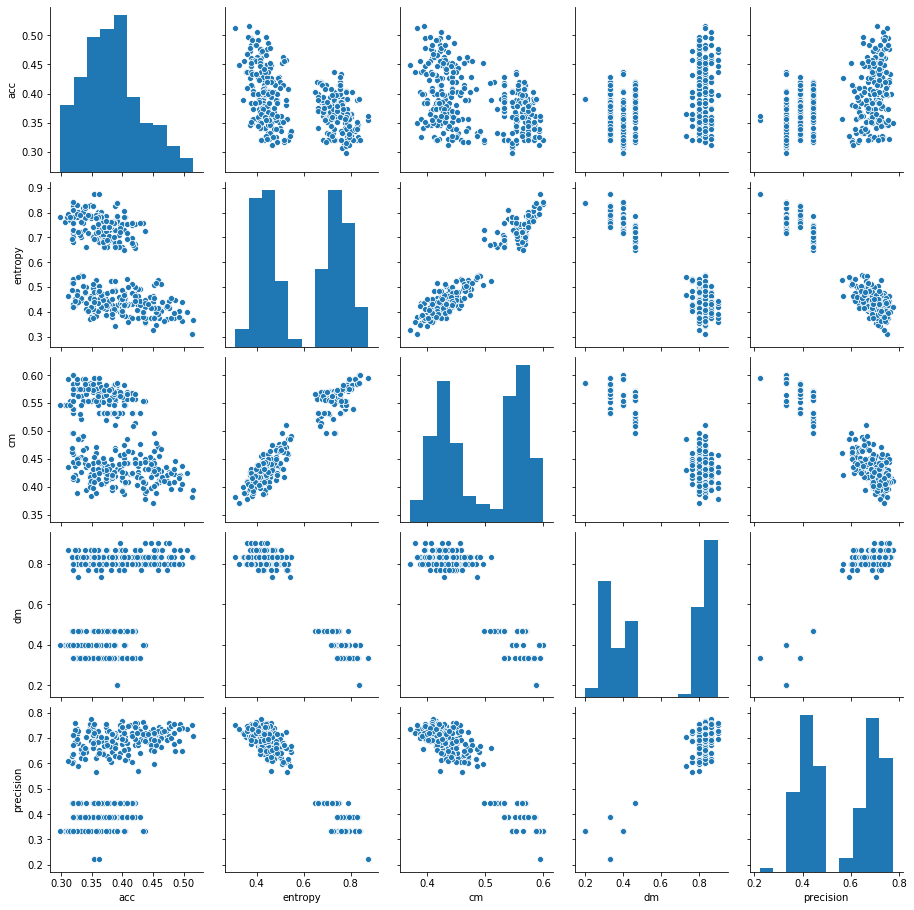

In [3]:
sb.pairplot(results[["acc", "entropy", "cm", "dm", "precision"]])

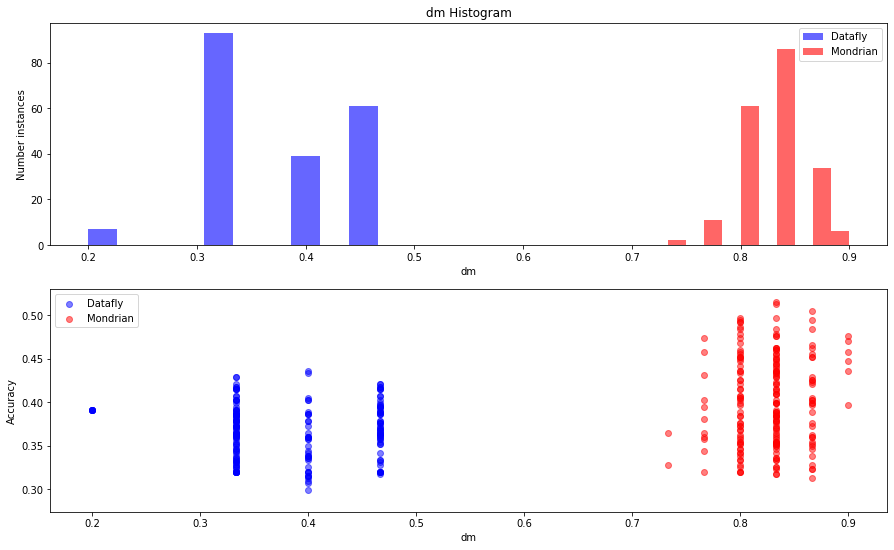

In [4]:
def plot_metric(metric):    
    fig, (ax1, ax2)= plt.subplots(2,1, figsize=(15,9))
    dataflys = results[results["algo"] == "datafly"]
    mondrians = results[results["algo"] == "mondrian"]
    
    ax1.hist(dataflys[metric], label="Datafly", color="b", alpha=.6)
    ax1.hist(mondrians[metric], label="Mondrian", color="r", alpha=.6)
    ax1.set_xlabel(metric)
    ax1.set_ylabel("Number instances")
    ax1.legend()
    ax1.set_title(f"{metric} Histogram")
    
    ax2.scatter(dataflys[metric], dataflys["acc"], c="b", alpha=0.5, label="Datafly")
    ax2.scatter(mondrians[metric], mondrians["acc"], c="r", alpha=0.5, label="Mondrian")
    ax2.set_xlabel(metric)
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    
plot_metric("dm")

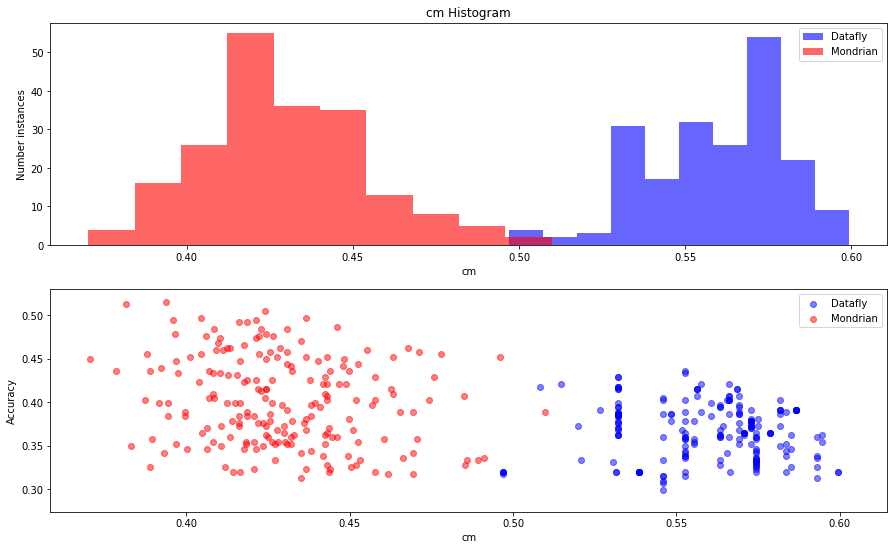

In [5]:
plot_metric("cm")

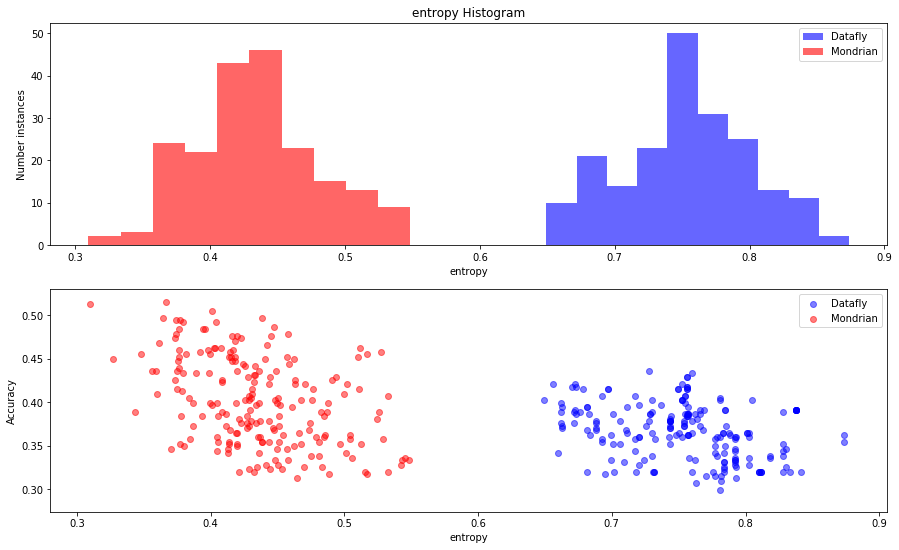

In [6]:
plot_metric("entropy")

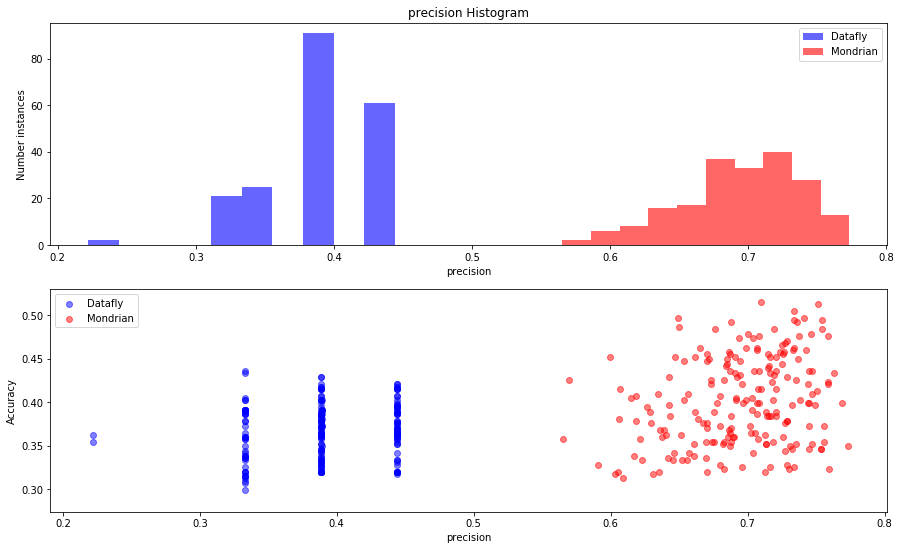

In [7]:
plot_metric("precision")

# Predicting Power

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def regress(regressor, algo_data):

    X = algo_data[regressor]
    y = algo_data["acc"]

    reg = LinearRegression()
    reg.fit(X, y)

    score = reg.score(X,y)
    return reg, score

def mse(reg, attributes):
    attrs = np.array(results[attributes])
    attrs = attrs.reshape(-1,1) if len(attrs) == 1 else attrs
    y_pred = reg.predict(attrs)
    y_true = results["acc"]
    mse = mean_squared_error(y_true, y_pred)
    return mse

mses = []

In [9]:
def fit_and_graph(regressor, algo_data):
    print(f"Regression on {algo_data['algo'].iloc[0]}")
    reg, score = regress([regressor], algo_data)
    coeff = reg.coef_
    intercept = reg.intercept_
    
    err = mse(reg, [regressor])
    
    print(f"p-value: {scipy.stats.pearsonr(algo_data[regressor],algo_data['acc'])[1]}")
    print(f"R2 Score: {score}")
    print(f"MSE: {err}")
    print(f"Coeffs: {coeff}")
    print(f"Intercept: {intercept}")
    
    x = np.linspace(0,1,100)
    l = coeff*x + intercept
    
    algo_data.plot.scatter(regressor, "acc", figsize=(15,6), grid=True, 
                           title=f"Linear regression of the Conditional Entropy ({algo_data['algo'].iloc[0]})")
            
    plt.plot(x,l)
    


### Entropy

Regression on datafly
p-value: 5.345932293444797e-06
R2 Score: 0.09954394039456825
MSE: 0.0020173464530129077
Coeffs: [-0.20363901]
Intercept: 0.5202533116885012

Regression on mondrian
p-value: 1.863530039789826e-10
R2 Score: 0.18582838385516331
MSE: 0.00829315298452861
Coeffs: [-0.47376707]
Intercept: 0.6076870338662491


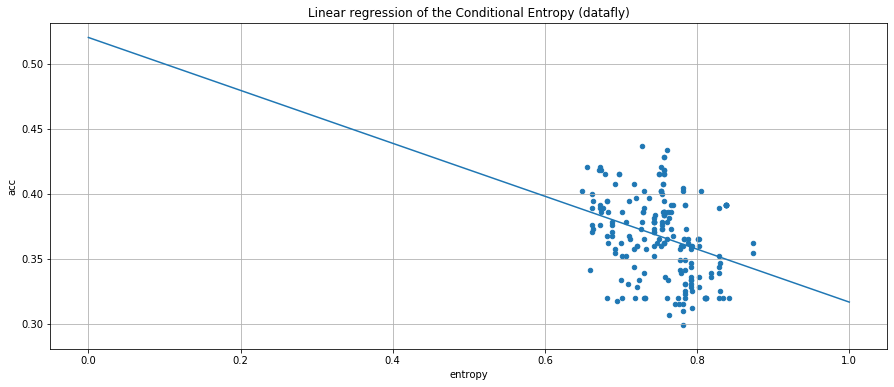

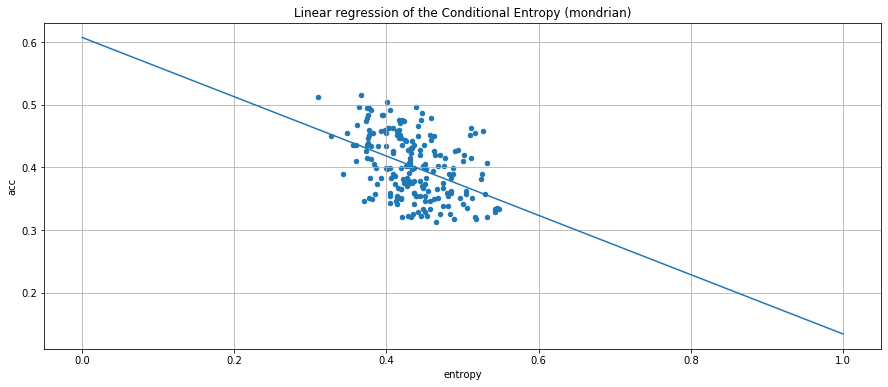

In [10]:
fit_and_graph("entropy", dataf)
print()
fit_and_graph("entropy", mondr)

### Classification Metric

Regression on datafly
p-value: 0.4680446296638004
R2 Score: 0.0026627099690480494
MSE: 0.002057571597168022
Coeffs: [-0.07609275]
Intercept: 0.4094812606692091

Regression on mondrian
p-value: 0.0030527028201702854
R2 Score: 0.04346065454808545
MSE: 0.0019816121346582782
Coeffs: [-0.43399003]
Intercept: 0.5878286779014481


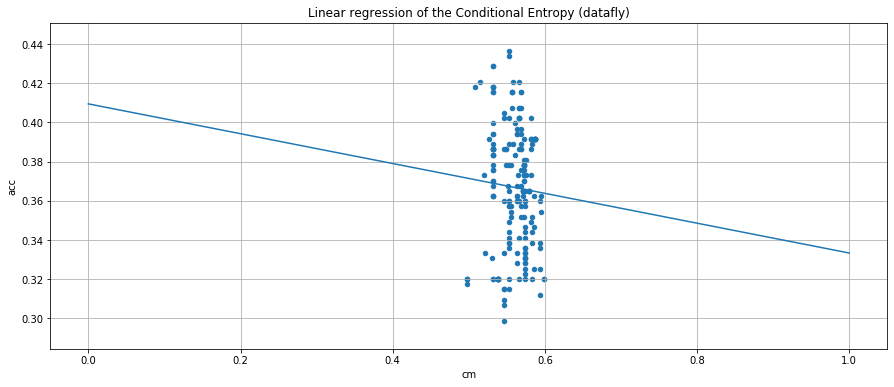

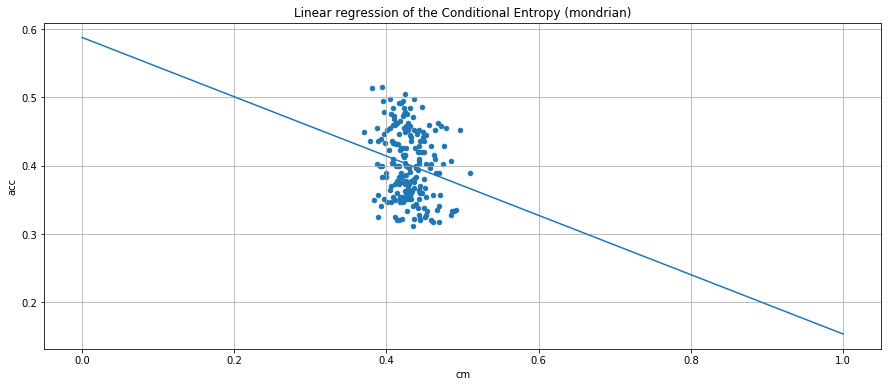

In [12]:
fit_and_graph("cm", dataf)
print()
fit_and_graph("cm", mondr)

### DM

Regression on datafly
p-value: 0.5203437551481386
R2 Score: 0.0020900174103174463
MSE: 0.0027427446109916775
Coeffs: [-0.02129255]
Intercept: 0.37507206682639654

Regression on mondrian
p-value: 0.13919538444360618
R2 Score: 0.011011429394109151
MSE: 0.00271755728988441
Coeffs: [0.17210977]
Intercept: 0.2592768954301369


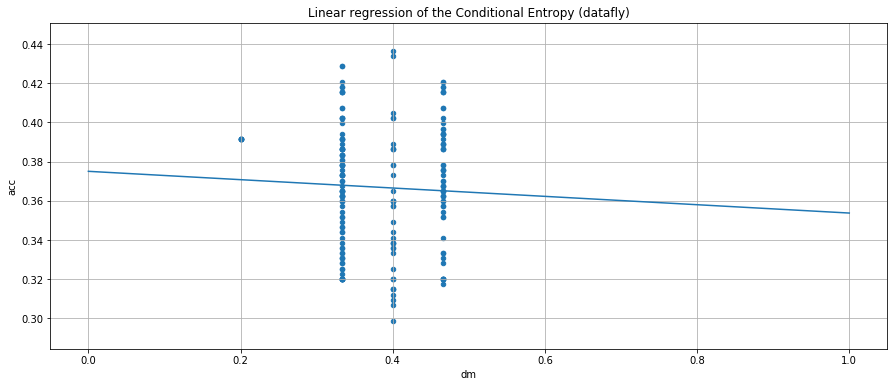

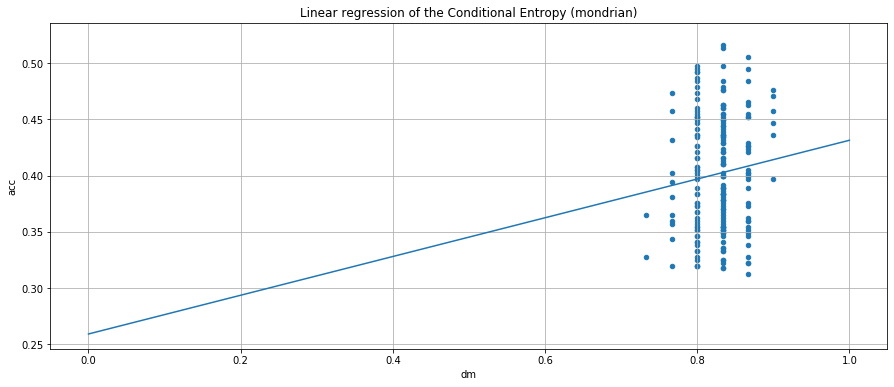

In [13]:
fit_and_graph("dm", dataf)
print()
fit_and_graph("dm", mondr)

### Precision


Regression on datafly
p-value: 0.04700999706894631
R2 Score: 0.01977651814447179
MSE: 0.0017230280769398839
Coeffs: [0.1004969]
Intercept: 0.32762391469100116

Regression on mondrian
p-value: 0.0001507298320274858
R2 Score: 0.0701416805810876
MSE: 0.00359941730712544
Coeffs: [0.31615237]
Intercept: 0.18192395479471746


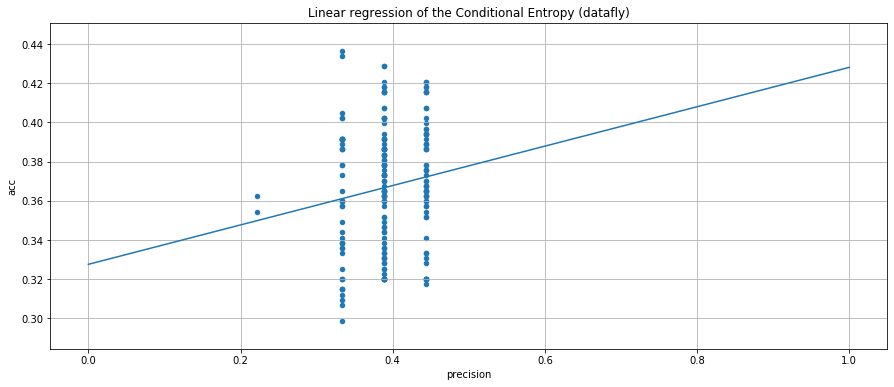

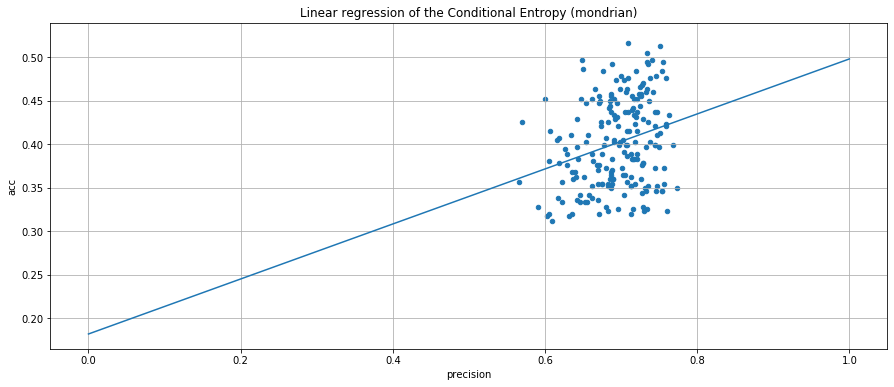

In [14]:
fit_and_graph("precision", dataf)
print()
fit_and_graph("precision", mondr)

### Multiple Metrics

In [63]:
metrics = ["entropy", "cm", "dm", "precision"]

res = []
for i in range(1,5):
    
    for comb in itertools.combinations(metrics, i):
        
        ms = list(comb)
        for alg in [dataf, mondr]:
            name = alg["algo"].iloc[0] 
            reg, score = regress(ms, alg)
            err = mse(reg, ms)
            p_val = scipy.stats.pearsonr(alg[ms[0]], alg['acc'])[1] if i == 1 else None
            res.append((str(ms), name, p_val, score, err))

            
df = pd.DataFrame(res, columns=["metrics", "algo", "p_value", "R2_score", "MSE_error"])
df = df.set_index(["metrics", "algo"])
pd.set_option('display.float_format', '{:.10f}'.format)
df

p_value     R2_score  \
metrics                              algo                                 
['entropy']                          datafly  0.0000053459 0.0995439404   
                                     mondrian 0.0000000002 0.1858283839   
['cm']                               datafly  0.4680446297 0.0026627100   
                                     mondrian 0.0030527028 0.0434606545   
['dm']                               datafly  0.5203437551 0.0020900174   
                                     mondrian 0.1391953844 0.0110114294   
['precision']                        datafly  0.0470099971 0.0197765181   
                                     mondrian 0.0001507298 0.0701416806   
['entropy', 'cm']                    datafly           nan 0.1152871286   
                                     mondrian          nan 0.2190332618   
['entropy', 'dm']                    datafly           nan 0.3038638941   
                                     mondrian          nan 0.1865620861   
['entropy', 'precision']             datafly           nan 0.1111978611   
                                     mondrian          nan 0.1868081338   
['cm', 'dm']                         datafly           nan 0.0078942810   
                                     mondrian          nan 0.0500333115   
['cm', 'precision']                  datafly           nan 0.0198575973   
                                     mondrian          nan 0.0770804110   
['dm', 'precision']                  datafly           nan 0.0430636508   
                                     mondrian          nan 0.0702521429   
['entropy', 'cm', 'dm']              datafly           nan 0.3177381796   
                                     mondrian          nan 0.2194830988   
['entropy', 'cm', 'precision']       datafly           nan 0.1290439356   
                                     mondrian          nan 0.2232887975   
['entropy', 'dm', 'precision']       datafly           nan 0.3093205212   
                                     mondrian          nan 0.1871368050   
['cm', 'dm', 'precision']            datafly           nan 0.0461150262   
                                     mondrian          nan 0.0773962996   
['entropy', 'cm', 'dm', 'precision'] datafly           nan 0.3245857499   
                                     mondrian          nan 0.2232888177   

                                                 MSE_error  
metrics                              algo                   
['entropy']                          datafly  0.0020173465  
                                     mondrian 0.0082931530  
['cm']                               datafly  0.0020575716  
                                     mondrian 0.0019816121  
['dm']                               datafly  0.0027427446  
                                     mondrian 0.0027175573  
['precision']                        datafly  0.0017230281  
                                     mondrian 0.0035994173  
['entropy', 'cm']                    datafly  0.0017047700  
                                     mondrian 0.0081754510  
['entropy', 'dm']                    datafly  0.0014612873  
                                     mondrian 0.0106406738  
['entropy', 'precision']             datafly  0.0017431609  
                                     mondrian 0.0090564478  
['cm', 'dm']                         datafly  0.0023584786  
                                     mondrian 0.0049086349  
['cm', 'precision']                  datafly  0.0017169043  
                                     mondrian 0.0041117965  
['dm', 'precision']                  datafly  0.0018811282  
                                     mondrian 0.0040452176  
['entropy', 'cm', 'dm']              datafly  0.0015494411  
                                     mondrian 0.0099725527  
['entropy', 'cm', 'precision']       datafly  0.0015654145  
                                     mondrian 0.0098244225  
['entropy', 'dm', 'precision']       datafly  0.0015319920  
   